In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch
warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

from termcolor import colored


import tensorflow.keras.backend as K

### Load and prepare data


 ************************ Data files have been prepared ***************************** 

Seed number for this set is: 13

 ****************** Training and validation sets have been prepared **************** 

 prepare_single_data 
 prepare_semisingle_data 
 prepare_mix_data


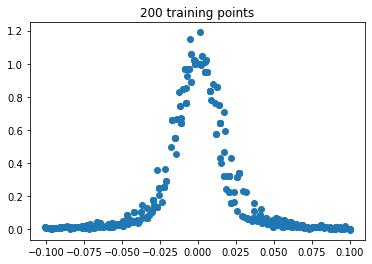

In [248]:
mode = 'Mixture'
%run EELS-ZLP.py

### Find uncertainties on data

44394


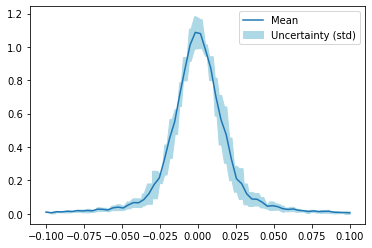

In [249]:
%run Functions.ipynb

nbins = 60

if mode == 'Mixture':
    x_train, y_train, x_val, y_val = prepare_mix_data()
if mode == 'Single':
    x_train, y_train = prepare_single_data()

# Create a plot of the mean & std 
plot_uncertainties(x_train, y_train)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train, variance_vector_t]

# Store output vectors for validation
df_val, cuts1_v, cuts2_v = ewd(x_val, y_val)
mean_v, std_v, count_v= binned_statistics(x_val, y_val)
variance_vector_v = vectorize_variance(x_val, y_val)
mean_vector_v = vectorize_mean(x_val, y_val)
#create one vector with (x_train, y_train, sigma_train)
df_val = np.c_[df_val, variance_vector_v]

## Neural Network 

### Create architecture

In [250]:
def make_model(inputs, n_outputs=1):

    hidden_layer_1 = tf.layers.dense(x, 5, activation=tf.nn.relu)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 5, activation=tf.nn.relu)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output

### Prepare data for training

In [251]:
tf.reset_default_graph()

x = tf.placeholder("float", [None, 1])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train)
print(N_train)
N_test = len(df_val)

predictions = make_model(x, 1)

cost = tf.reduce_mean(tf.square((y-predictions)/sigma))
eta = 1.2e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta).minimize(cost)

train_x = np.array((df_train[:,0])).reshape(N_train,1)
train_y = np.array(df_train[:,1]).reshape(N_train,1)
train_sigma = np.array(df_train[:,2]).reshape(N_train,1)

test_x = np.array((df_train[:N_test,0])).reshape(N_test,1)
test_y = np.array(df_train[:N_test,1]).reshape(N_test,1)
test_sigma = np.array(df_train[:N_test,2]).reshape(N_test,1)



44394


### Train and validate

In [252]:
training_epochs = 10000
max_rising_epochs = 2000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 500
prev_test_cost = np.inf
prev_epoch=0
avg_cost = 0.0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    
    for epoch in range(training_epochs):

        _, c = sess.run([optimizer, cost], 
                        feed_dict={
                            x: train_x, 
                            y: train_y, 
                            sigma: train_sigma
                        })
        
        avg_cost = c 
        
        test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})
        
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "| Train cost=", "{:.9f}".format(avg_cost), "| Test cost=", "{:.9f}".format(test_cost))
                         
        if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
            print(colored("\n The minimization stopped...","red"))
            print("Epoch:", '%04d' % (epoch+1), "| Best Train cost=", "{:.9f}".format(avg_cost), "| Test cost=", "{:.9f}".format(test_cost))
            print("Overfitting regime was about to start at epoch: ",epoch)
            break
            
        elif test_cost < prev_test_cost:
            
            prev_test_cost = test_cost
            prev_epoch = epoch
        
    
    print("Optimization Finished!")
    predictions_values = sess.run(predictions, 
                        feed_dict={
                            x: train_x, 
                            y: train_y
                        })

Epoch: 0001 | Train cost= 65.768196106 | Test cost= 92.858642578
Epoch: 0501 | Train cost= 21.873870850 | Test cost= 1.890005350
Epoch: 1001 | Train cost= 9.241379738 | Test cost= 2.095703363
Epoch: 1501 | Train cost= 3.094857216 | Test cost= 2.124920368
Epoch: 2001 | Train cost= 2.070314646 | Test cost= 1.284123659
Epoch: 2501 | Train cost= 1.701029778 | Test cost= 1.286692619
Epoch: 3001 | Train cost= 1.662285089 | Test cost= 1.446182370
Epoch: 3501 | Train cost= 1.436686039 | Test cost= 1.314013124
Epoch: 4001 | Train cost= 1.375967145 | Test cost= 1.321377873

 The minimization stopped...
Epoch: 4070 | Best Train cost= 1.371582747 | Test cost= 1.322870493
Overfitting regime was about to start at epoch:  4069
Optimization Finished!


### Plot outputs

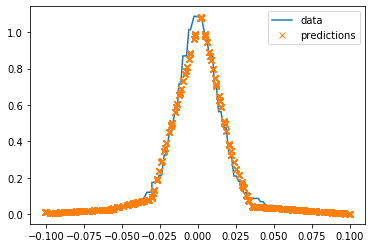

In [253]:
plt.plot(df_train[:,0], mean_vector_t, label='data')
plt.plot(train_x, predictions_values, 'x', label='predictions')
plt.legend()
plt.show()